<a href="https://colab.research.google.com/github/LakshmiNittala/Forecasting/blob/main/LMW_Nixtla_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -Uqq nixtla utilsforecast
from nixtla.utils import in_colab

# Fine-tuning with a specific loss function

When fine-tuning, the model trains on your dataset to tailor its predictions to your particular scenario. As such, it is possible to specify the loss function used during fine-tuning.\
\
Specifically, you can choose from:

* `"default"` - a proprietary loss function that is robust to outliers
* `"mae"` - mean absolute error
* `"mse"` - mean squared error
* `"rmse"` - root mean squared error
* `"mape"` - mean absolute percentage error
* `"smape"` - symmetric mean absolute percentage error

## 1. Import packages
First, we import the required packages and initialize the Nixtla client.

In [ ]:
import pandas as pd
from nixtla import NixtlaClient
from utilsforecast.losses import mae, mse, rmse, mape, smape

In [ ]:
#  Instantiate the NixtlaClient
nixtla_client = NixtlaClient(
    api_key = 'nixtla-tok-txdSDTfXqjrxA1Rhf01EJ57OfXbW28sU7QCq0MEWII5cKZNJZXhUyxm5uQz4q0l2qb03ISzdLLcBV2en'
    )

## 2. Load data

Let's fine-tune the model on a dataset using the mean absolute error (MAE).\
\
For that, we simply pass the appropriate string representing the loss function to the `finetune_loss` parameter of the `forecast` method.

In [ ]:
# Load data from content folder in colab
parts_time_series = pd.read_csv('sample_data/all_parts_time_series.csv')
parts_time_series.head()

,year_month,quantity,item
0,2015 Apr,17.5,312500615
1,2015 May,14.0,312500615
2,2015 Jun,40.0,312500615
3,2015 Jul,10.0,312500615
4,2015 Aug,5.0,312500615


In [ ]:
# Convert the year_month column to timestamp object
parts_time_series['year_month'] = pd.to_datetime(parts_time_series['year_month'], format='%Y %b')
# convert to %Y %m format so that aggregation later on works fine at the montly level
parts_time_series['year_month'] = pd.to_datetime(parts_time_series['year_month'], format='%Y %m')
parts_time_series.head()

# Set the year_month column as the index
parts_time_series.set_index('year_month', inplace=True)

print(parts_time_series)

            quantity       item
year_month                     
2015-04-01      17.5  312500615
2015-05-01      14.0  312500615
2015-06-01      40.0  312500615
2015-07-01      10.0  312500615
2015-08-01       5.0  312500615
...              ...        ...
2024-01-01      48.0  7S1564049
2024-02-01      13.0  7S1564049
2024-03-01      25.0  7S1564049
2024-04-01      21.0  7S1564049
2024-05-01      21.0  7S1564049

[382264 rows x 2 columns]


In [ ]:
def series_fill(item):
    # Resample the time series to monthly frequency, fill missing values with 0
    return item.resample('M').asfreq().fillna(0)

# Apply the resampling function to each unique item in the 'item' column
parts_time_series_filled = parts_time_series.groupby('item').apply(series_fill)

# Reset the index to flatten the DataFrame structure after groupby
# drop the existing 'item' column as it will be added as a column from the index
parts_time_series_filled = parts_time_series_filled.reset_index(drop=True)

# Display the result
print(parts_time_series_filled)


        quantity  item
0            0.0     0
1            0.0     0
2            0.0     0
3            0.0     0
4            0.0     0
...          ...   ...
382259       0.0     0
382260       0.0     0
382261       0.0     0
382262       0.0     0
382263       0.0     0

[382264 rows x 2 columns]


In [ ]:
# Create subset to capture January 2021 onwards
# parts_time_series_jan_2021 = parts_time_series[parts_time_series.index >= '2021-01-01'] # Use .index to access the index of the DataFrame
# parts_time_series_jan_2021.head()

# NIXTLA needs 36 data points in a series. So, skipping the above part for now since it is giving only 21 after bimonthly aggregation

In [ ]:
item_series = parts_time_series[parts_time_series['item'] == "400209891"]
item_series.head()

,quantity,item
year_month,,
2015-04-01,244.0,400209891
2015-05-01,134.0,400209891
2015-06-01,115.0,400209891
2015-07-01,242.0,400209891
2015-08-01,275.0,400209891


In [ ]:
# resample such that the last resampling period exactly ends at the last row in the item series. closed = 'left' and label = 'right' is helping
item_bimonthly_series = item_series.resample('2M', closed='left', label = 'right').sum()
item_bimonthly_series.tail()

,quantity,item
year_month,,
2023-09-30,284.0,400209891400209891
2023-11-30,249.0,400209891400209891
2024-01-31,190.0,400209891400209891
2024-03-31,156.0,400209891400209891
2024-05-31,342.0,400209891400209891


In [ ]:
# Adjust the item column
item_bimonthly_series['item'] = '400209891'
item_bimonthly_series.head()

,quantity,item
year_month,,
2015-05-31,378.0,400209891
2015-07-31,357.0,400209891
2015-09-30,413.0,400209891
2015-11-30,349.0,400209891
2016-01-31,301.0,400209891


In [ ]:
# Reset index to let pandas create default index. Nixtla needs the time column be separate from index
item_bimonthly_series = item_bimonthly_series.reset_index()
item_bimonthly_series.head()

,year_month,quantity,item
0,2015-05-31,378.0,400209891
1,2015-07-31,357.0,400209891
2,2015-09-30,413.0,400209891
3,2015-11-30,349.0,400209891
4,2016-01-31,301.0,400209891


In [ ]:
# Checking that the year_month still retains the datetime property
item_bimonthly_series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   year_month  55 non-null     datetime64[ns]
 1   quantity    55 non-null     float64       
 2   item        55 non-null     object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.4+ KB


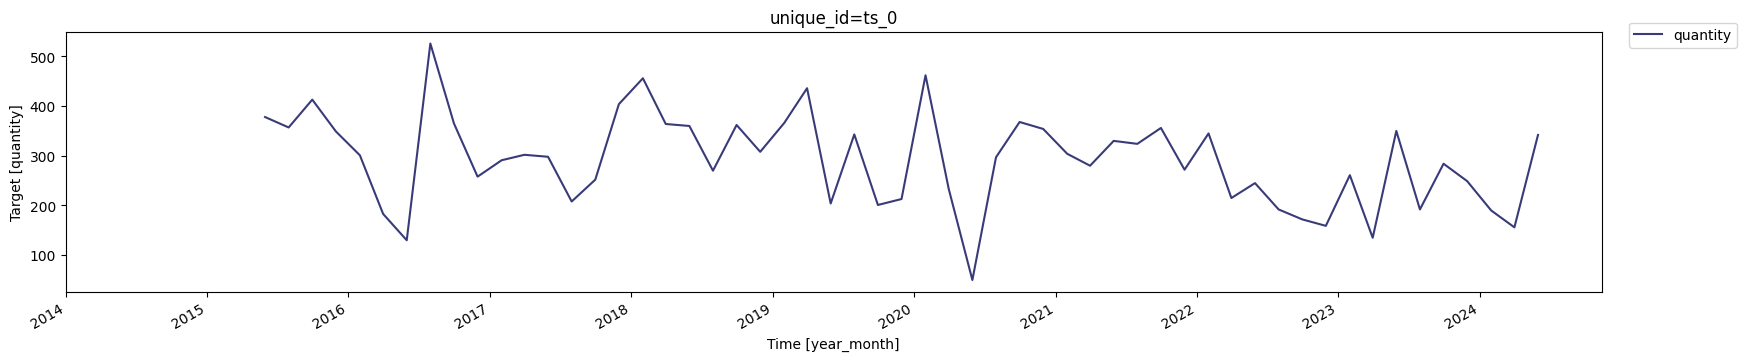

In [ ]:
# Plot the data using the index as the time column
nixtla_client.plot(item_bimonthly_series, time_col='year_month', target_col='quantity')

In [ ]:
# add a log transformation and replot
import numpy as np
from numpy import log
item_bimonthly_series['log_quantity'] = item_bimonthly_series['quantity'].apply(lambda x: log(1+ x))
item_bimonthly_series.head()

,year_month,quantity,item,log_quantity
0,2015-05-31,378.0,400209891,5.937536
1,2015-07-31,357.0,400209891,5.880533
2,2015-09-30,413.0,400209891,6.025866
3,2015-11-30,349.0,400209891,5.857933
4,2016-01-31,301.0,400209891,5.710427


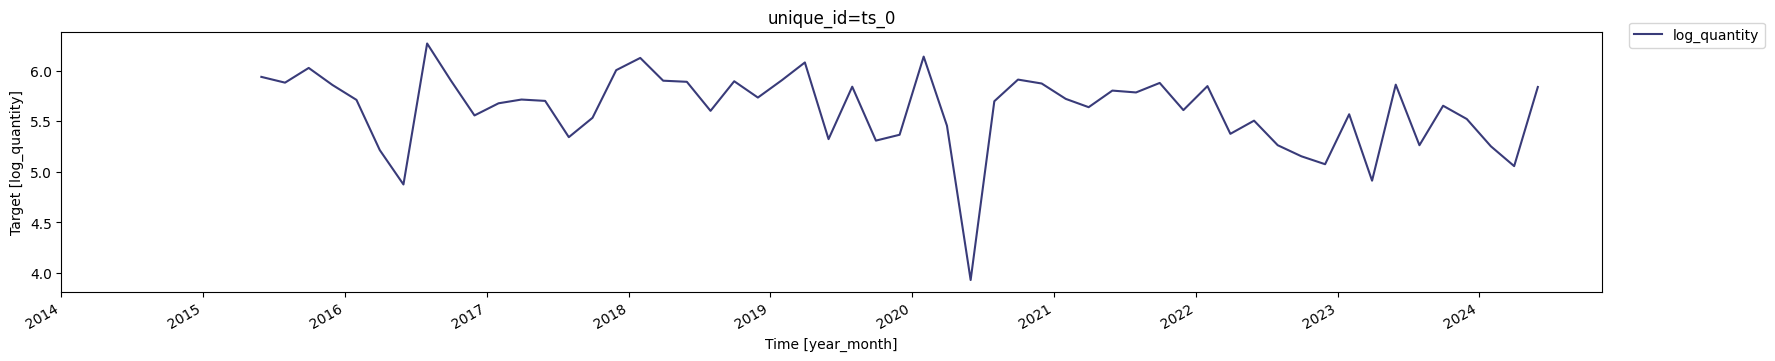

In [ ]:
# Now plot the time series using log_quantity
nixtla_client.plot(item_bimonthly_series, time_col='year_month', target_col='log_quantity')

In [ ]:
# Create train and test sets using temp
train = item_bimonthly_series[:-1]
test = item_bimonthly_series[-1:]

## 3. Fine-tuning with Mean Absolute Error

Let's fine-tune the model on a dataset using the Mean Absolute Error (MAE).\
\
For that, we simply pass the appropriate string representing the loss function to the `finetune_loss` parameter of the `forecast` method.

In [ ]:
timegpt_fcst_finetune_mae_df = nixtla_client.forecast(
    df=train,
    h=1,
    finetune_steps=10,
    finetune_loss='mae',   # Set your desired loss function
    time_col='year_month',
    target_col='quantity',
)

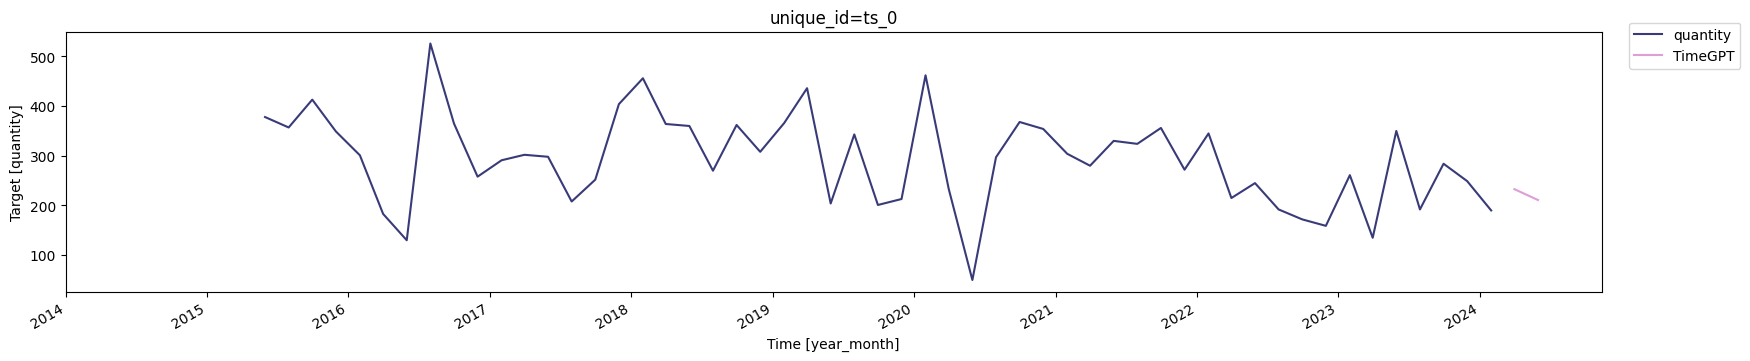

In [ ]:
nixtla_client.plot(
    train, timegpt_fcst_finetune_mae_df,
    time_col='year_month', target_col='quantity',
)

Now, depending on your data, you will use a specific error metric to accurately evaluate your forecasting model's performance.\
\
Below is a non-exhaustive guide on which metric to use depending on your use case.\
\
**Mean absolute error (MAE)**\
\
<img src="https://latex.codecogs.com/svg.image?\mathrm{MAE}(\mathbf{y}_{\tau}, \mathbf{\hat{y}}_{\tau}) = \frac{1}{H} \sum^{t+H}_{\tau=t+1} |y_{\tau} - \hat{y}_{\tau}|" />

- Robust to outliers
- Easy to understand
- You care equally about all error sizes
- Same units as your data

**Mean squared error (MSE)**\
\
<img src="https://latex.codecogs.com/svg.image?\mathrm{MSE}(\mathbf{y}_{\tau}, \mathbf{\hat{y}}_{\tau}) = \frac{1}{H} \sum^{t+H}_{\tau=t+1} (y_{\tau} - \hat{y}_{\tau})^{2}" />

- You want to penalize large errors more than small ones
- Sensitive to outliers
- Used when large errors must be avoided
- *Not* the same units as your data

**Root mean squared error (RMSE)**\
\
<img src="https://latex.codecogs.com/svg.image?\mathrm{RMSE}(\mathbf{y}_{\tau}, \mathbf{\hat{y}}_{\tau}) = \sqrt{\frac{1}{H} \sum^{t+H}_{\tau=t+1} (y_{\tau} - \hat{y}_{\tau})^{2}}" />

- Brings the MSE back to original units of data
- Penalizes large errors more than small ones

**Mean absolute percentage error (MAPE)**\
\
<img src="https://latex.codecogs.com/svg.image?\mathrm{MAPE}(\mathbf{y}_{\tau}, \mathbf{\hat{y}}_{\tau}) = \frac{1}{H} \sum^{t+H}_{\tau=t+1} \frac{|y_{\tau}-\hat{y}_{\tau}|}{|y_{\tau}|}" />

- Easy to understand for non-technical stakeholders
- Expressed as a percentage
- Heavier penalty on positive errors over negative errors
- To be avoided if your data has values close to 0 or equal to 0

**Symmmetric mean absolute percentage error (sMAPE)**\
\
<img src="https://latex.codecogs.com/svg.image?\mathrm{SMAPE}_{2}(\mathbf{y}_{\tau}, \mathbf{\hat{y}}_{\tau}) = \frac{1}{H} \sum^{t+H}_{\tau=t+1} \frac{|y_{\tau}-\hat{y}_{\tau}|}{|y_{\tau}|+|\hat{y}_{\tau}|}" />

- Fixes bias of MAPE
- Equally senstitive to over and under forecasting
- To be avoided if your data has values close to 0 or equal to 0

With TimeGPT, you can choose your loss function during fine-tuning as to maximize the model's performance metric for your particular use case.\
\
Let's run a small experiment to see how each loss function improves their associated metric when compared to the default setting.

In [ ]:
# Below is code to evaluate different loss functions

losses = ['default', 'mae', 'mse', 'rmse', 'mape', 'smape']

test = test.copy()

for loss in losses:
    preds_df = nixtla_client.forecast(
    df=train,
    h=1,
    finetune_steps=300,
    finetune_loss=loss,
    time_col='year_month',
    target_col='quantity')

    preds = preds_df['TimeGPT'].values

    test.loc[:,f'TimeGPT_{loss}'] = preds

loss_fct_dict = {
    "mae": mae,
    "mse": mse,
    "rmse": rmse,
    "mape": mape,
    "smape": smape
}

pct_improv = []

for loss in losses[1:]:
    evaluation = loss_fct_dict[f'{loss}'](test, models=['TimeGPT_default', f'TimeGPT_{loss}'], id_col='item', target_col='quantity')
    pct_diff = (evaluation['TimeGPT_default'] - evaluation[f'TimeGPT_{loss}']) / evaluation['TimeGPT_default'] * 100
    pct_improv.append(round(pct_diff, 2))

data = {
    'mae': pct_improv[0].values,
    'mse': pct_improv[1].values,
    'rmse': pct_improv[2].values,
    'mape': pct_improv[3].values,
    'smape': pct_improv[4].values
}

metrics_df = pd.DataFrame(data)
metrics_df.index = ['Metric improvement (%)']

metrics_df

,mae,mse,rmse,mape,smape
Metric improvement (%),0.52,4.31,1.41,-13.65,18.94


In [ ]:
# This is for log-transformed predictions

# Create a column in test to convert the TimeGPT_smape values into inverse log transform values
test['TimeGPT_smape_inv'] = test['TimeGPT_smape'].apply(lambda x: np.exp(x) - 1)
test['TimeGPT_mape_inv'] = test['TimeGPT_mape'].apply(lambda x: np.exp(x) - 1)
test['TimeGPT_rmse_inv'] = test['TimeGPT_rmse'].apply(lambda x: np.exp(x) - 1)
test['TimeGPT_mse_inv'] = test['TimeGPT_mse'].apply(lambda x: np.exp(x) - 1)
test['TimeGPT_mae_inv'] = test['TimeGPT_mae'].apply(lambda x: np.exp(x) - 1)

# Compute the percent deviation of this column from the quantity column and store it as a separate column
test['percent_deviation_smape'] = test['TimeGPT_smape_inv']/ test['quantity']
test['percent_deviation_mape'] = test['TimeGPT_mape_inv']/ test['quantity']
test['percent_deviation_rmse'] = test['TimeGPT_rmse_inv']/ test['quantity']
test['percent_deviation_mae'] = test['TimeGPT_mae_inv']/ test['quantity']
test['percent_deviation_mse'] = test['TimeGPT_mse_inv']/ test['quantity']

In [ ]:
# This is for regular predictions

# Compute the percent deviation of this column from the quantity column and store it as a separate column
test['percent_deviation_smape'] = test['TimeGPT_smape']/ test['quantity']
test['percent_deviation_mape'] = test['TimeGPT_mape']/ test['quantity']
test['percent_deviation_rmse'] = test['TimeGPT_rmse']/ test['quantity']
test['percent_deviation_mae'] = test['TimeGPT_mae']/ test['quantity']
test['percent_deviation_mse'] = test['TimeGPT_mse']/ test['quantity']

In [ ]:
test

,year_month,quantity,item,log_quantity,TimeGPT_default,TimeGPT_mae,TimeGPT_mse,TimeGPT_rmse,TimeGPT_mape,TimeGPT_smape,percent_deviation_smape,percent_deviation_mape,percent_deviation_rmse,percent_deviation_mae,percent_deviation_mse
54,2024-05-31,342.0,400209891,5.83773,186.82903,187.6324,190.21303,189.02246,165.6528,210.57646,0.615721,0.484365,0.552697,0.548633,0.556178


At the end of the exercise the conclusion is that we will use rmse as the loss function.
Add item types to the various item numbers.
Log tranformation is givign worse results.


In [ ]:
parts_time_series.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 382264 entries, 2015-04-01 to 2024-05-01
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   quantity  382264 non-null  float64
 1   item      382264 non-null  object 
dtypes: float64(1), object(1)
memory usage: 8.7+ MB


In [ ]:
# This code, aggregates every time series at the bimonhtly level, ending with the last month in the data.


# Define a function to resample for each item
def series_aggregate(item):
    return item.resample('2M', closed='left', label = 'right').sum().drop(columns=['item']) # Drop the 'item' column here

# Apply the resampling function to each unique series
all_bimonthly_series = parts_time_series.groupby('item').apply(series_aggregate).reset_index()

# Display the result
print(all_bimonthly_series)

             item year_month  quantity
0       312500615 2015-05-31      31.5
1       312500615 2015-07-31      50.0
2       312500615 2015-09-30      15.0
3       312500615 2015-11-30      10.0
4       312500615 2016-01-31      19.0
...           ...        ...       ...
191532  7S1564049 2023-09-30      46.0
191533  7S1564049 2023-11-30      60.0
191534  7S1564049 2024-01-31      67.0
191535  7S1564049 2024-03-31      38.0
191536  7S1564049 2024-05-31      42.0

[191537 rows x 3 columns]


In [ ]:
item_series = all_bimonthly_series[all_bimonthly_series['item'] == "400209891"]
item_series.head()

,item,year_month,quantity
800,400209891,2015-05-31,378.0
801,400209891,2015-07-31,357.0
802,400209891,2015-09-30,413.0
803,400209891,2015-11-30,349.0
804,400209891,2016-01-31,301.0


In [ ]:
# Now we will try predicting multiseries
# We will first create a two item multiseries
two_item_series = all_bimonthly_series[(all_bimonthly_series['item']=="400209891") | (all_bimonthly_series['item']=="312500615")]
print(two_item_series)

          item year_month  quantity
0    312500615 2015-05-31      31.5
1    312500615 2015-07-31      50.0
2    312500615 2015-09-30      15.0
3    312500615 2015-11-30      10.0
4    312500615 2016-01-31      19.0
..         ...        ...       ...
850  400209891 2023-09-30     284.0
851  400209891 2023-11-30     249.0
852  400209891 2024-01-31     190.0
853  400209891 2024-03-31     156.0
854  400209891 2024-05-31     342.0

[110 rows x 3 columns]


In [ ]:
# Find the earliest bimonth in each item
earliest_bimonth = two_item_series.groupby('item')['year_month'].min()
print(earliest_bimonth)

item
312500615   2015-05-31
400209891   2015-05-31
Name: year_month, dtype: datetime64[ns]


In [ ]:
# Find how many rows for each item
num_rows = two_item_series.groupby('item').size()
print(num_rows)

item
312500615    55
400209891    55
dtype: int64


In [ ]:
# Create test and train set by first grouping by item and then picking the last two observations as test
test = two_item_series.groupby('item').tail(2)
train = two_item_series.drop(test.index)


In [ ]:
# Below is code to evaluate different loss functions

losses = ['default', 'mae', 'mse', 'rmse', 'mape', 'smape']

test = test.copy()

for loss in losses:
    preds_df = nixtla_client.forecast(
    df=train,
    h=2,
    freq='2M',
    finetune_steps=300,
    finetune_loss=loss,
    time_col='year_month',
    target_col='quantity')

    preds = preds_df['TimeGPT'].values

    test.loc[:,f'TimeGPT_{loss}'] = preds



In [ ]:
loss_fct_dict = {
    "mae": mae,
    "mse": mse,
    "rmse": rmse,
    "mape": mape,
    "smape": smape
}

pct_improv = []

for loss in losses[1:]:
    evaluation = loss_fct_dict[f'{loss}'](test, models=['TimeGPT_default', f'TimeGPT_{loss}'], id_col='item', target_col='quantity')
    pct_diff = (evaluation['TimeGPT_default'] - evaluation[f'TimeGPT_{loss}']) / evaluation['TimeGPT_default'] * 100
    pct_improv.append(round(pct_diff, 2))

data = {
    'mae': pct_improv[0].values,
    'mse': pct_improv[1].values,
    'rmse': pct_improv[2].values,
    'mape': pct_improv[3].values,
    'smape': pct_improv[4].values
}

metrics_df = pd.DataFrame(data)
metrics_df.index = ['Metric improvement (%)']

metrics_df

In [ ]:
all_bimonthly_series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191537 entries, 0 to 191536
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   item        191537 non-null  object        
 1   year_month  191537 non-null  datetime64[ns]
 2   quantity    191537 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 4.4+ MB


In [ ]:
# groupby item and count number of rows in each
num_rows = all_bimonthly_series.groupby('item').size()
print(num_rows)

item
312500615    55
312501025    61
312507000    55
312507010    61
312507060    55
             ..
7S0746554    67
7S0809313    67
7S1048489    67
7S1383248    23
7S1564049    67
Length: 3488, dtype: int64


In [ ]:
# groupby item and find the earliest timestamp in each
earliest_timestamp = all_bimonthly_series.groupby('item')['year_month'].min()
print(earliest_timestamp)

item
312500615   2015-05-31
312501025   2014-05-31
312507000   2015-05-31
312507010   2014-05-31
312507060   2015-05-31
               ...    
7S0746554   2013-05-31
7S0809313   2013-05-31
7S1048489   2013-05-31
7S1383248   2020-09-30
7S1564049   2013-05-31
Name: year_month, Length: 3488, dtype: datetime64[ns]


In [ ]:
# in the earliest timestamp, find the latest one
latest_timestamp = earliest_timestamp.max()
print(latest_timestamp)

2023-08-31 00:00:00


In [ ]:
# give the item number for this one
item_number = earliest_timestamp[earliest_timestamp == latest_timestamp].index[0]
print(item_number)

449218283


In [ ]:
# display the time series for this item
item_series = all_bimonthly_series[all_bimonthly_series['item'] == item_number]
print(item_series)

            item year_month  quantity
54218  449218283 2023-08-31       2.0
54219  449218283 2023-10-31       4.0
54220  449218283 2023-12-31       3.0
54221  449218283 2024-02-29       3.0
54222  449218283 2024-04-30       2.0
54223  449218283 2024-06-30       2.0


In [ ]:

# in the all_bimonthly_series dataframe , groupby item and find the last timestamp for each
last_timestamp = all_bimonthly_series.groupby('item')['year_month'].max()
print(last_timestamp)


item
312500615   2024-05-31
312501025   2024-05-31
312507000   2024-05-31
312507010   2024-05-31
312507060   2024-05-31
               ...    
7S0746554   2024-05-31
7S0809313   2024-05-31
7S1048489   2024-05-31
7S1383248   2024-05-31
7S1564049   2024-05-31
Name: year_month, Length: 3488, dtype: datetime64[ns]


In [ ]:
# find the item numbers for which the last timestamp is not 2024-05-31
item_numbers = last_timestamp[last_timestamp != '2024-05-31']

In [ ]:
item_numbers

,year_month
item,
313600070,2024-06-30
314100030,2024-06-30
400202051,2024-06-30
401509290,2024-06-30
402112210,2024-06-30
...,...
7G0132970,2024-06-30
7G0301090,2024-06-30
7G0305557,2024-06-30


In [ ]:
# From the parts_time_series dataframe, subset the time series with item='400202051'
item_series = parts_time_series[parts_time_series['item'] == '400202051']
item_series.tail()



,quantity,item
year_month,,
2024-01-01,60.0,400202051
2024-02-01,20.0,400202051
2024-03-01,25.0,400202051
2024-04-01,60.0,400202051
2024-05-01,31.0,400202051


In [ ]:
print(item_series)

In [ ]:

test = item_series.resample('2M', closed='right', label = 'right').sum()
test.head()

,quantity,item
year_month,,
2015-05-31,3.0,400202051
2015-07-31,41.0,400202051400202051
2015-09-30,80.0,400202051400202051
2015-11-30,74.0,400202051400202051
2016-01-31,47.0,400202051400202051


In [ ]:
parts_time_series.groupby('item').size()

,0
item,
312500615,110
312501025,122
312507000,110
312507010,122
312507060,110
...,...
7S0746554,134
7S0809313,134
7S1048489,134


In [ ]:
# Reset index to let pandas create default index. Nixtla needs the time column be separate from index
parts_multi_series = parts_time_series.reset_index()
parts_multi_series.head()


,year_month,quantity,item
0,2015-04-01,17.5,312500615
1,2015-05-01,14.0,312500615
2,2015-06-01,40.0,312500615
3,2015-07-01,10.0,312500615
4,2015-08-01,5.0,312500615


In [ ]:
# rename the year_month column as ds, quantity column as y and item as unique_id
parts_multi_series = parts_multi_series.rename(columns={'year_month': 'ds', 'quantity': 'y', 'item': 'unique_id'})
parts_multi_series.head()

,ds,y,unique_id
0,2015-04-01,17.5,312500615
1,2015-05-01,14.0,312500615
2,2015-06-01,40.0,312500615
3,2015-07-01,10.0,312500615
4,2015-08-01,5.0,312500615


In [ ]:
parts_multi_series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382264 entries, 0 to 382263
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   ds         382264 non-null  datetime64[ns]
 1   y          382264 non-null  float64       
 2   unique_id  382264 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 8.7+ MB


In [ ]:
parts_multi_series.info()

NameError: name 'parts_multi_series' is not defined

In [ ]:
# groupby item and find the number of rows in each
num_rows = parts_multi_series.groupby('unique_id').size()
print(num_rows)

unique_id
312500615    110
312501025    122
312507000    110
312507010    122
312507060    110
            ... 
7S0746554    134
7S0809313    134
7S1048489    134
7S1383248     46
7S1564049    134
Length: 3488, dtype: int64


In [ ]:
# what is the minimum
min_rows = num_rows.min()
print(min_rows)

11


In [ ]:
# how many item number have less than 36 rows
num_items = (num_rows < 36).sum()
print(num_items)

103


In [ ]:
# delete rows with these item numbers from parts_multi_series and save with a new name
parts_new_multi_series = parts_multi_series[parts_multi_series['unique_id'].isin(num_rows[num_rows >= 36].index)]
parts_new_multi_series.head()

,ds,y,unique_id
0,2015-04-01,17.5,312500615
1,2015-05-01,14.0,312500615
2,2015-06-01,40.0,312500615
3,2015-07-01,10.0,312500615
4,2015-08-01,5.0,312500615


In [ ]:
# number of unique_id in this dataframe
unique_ids = parts_new_multi_series['unique_id'].nunique()
print(unique_ids)

3385


In [ ]:
timegpt_fcst_multiseries_df = nixtla_client.forecast(df=parts_new_multi_series, h=1, level=[80, 90], finetune_steps=300,  finetune_loss='rmse')
timegpt_fcst_multiseries_df.head()

,unique_id,ds,TimeGPT,TimeGPT-hi-80,TimeGPT-hi-90,TimeGPT-lo-80,TimeGPT-lo-90
0,312500615,2024-06-01,21.172838,31.838047,33.171196,10.507631,9.174480
1,312501025,2024-06-01,47.866814,67.454590,69.903060,28.279036,25.830563
2,312507000,2024-06-01,301.312620,443.651580,461.443970,158.973660,141.181290
3,312507010,2024-06-01,766.194030,838.634000,847.688960,693.754100,684.699100
4,312507060,2024-06-01,125.979050,199.705890,208.921750,52.252205,43.036350


In [ ]:
save the dataframe to csv
parts_new_multi_series.to_csv('parts_new_multi_series.csv', index=False)

# TimeGPT Multiseries Forecasting

In [ ]:
!pip install -Uqq nixtla utilsforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 702.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from nixtla import NixtlaClient
from utilsforecast.losses import mae, mse, rmse, mape, smape

#  Instantiate the NixtlaClient
nixtla_client = NixtlaClient(
    api_key = 'nixtla-tok-txdSDTfXqjrxA1Rhf01EJ57OfXbW28sU7QCq0MEWII5cKZNJZXhUyxm5uQz4q0l2qb03ISzdLLcBV2en'
    )

# Load data from content folder in colab
parts_multi_series = pd.read_csv('sample_data/all_parts_time_series.csv')
parts_multi_series.head()

,year_month,quantity,item
0,2015 Apr,17.5,312500615
1,2015 May,14.0,312500615
2,2015 Jun,40.0,312500615
3,2015 Jul,10.0,312500615
4,2015 Aug,5.0,312500615


In [ ]:
# Convert the year_month column to timestamp object
parts_multi_series['year_month'] = pd.to_datetime(parts_multi_series['year_month'], format='%Y %b')
# convert to %Y %m format so that aggregation later on works fine at the montly level
parts_multi_series['year_month'] = pd.to_datetime(parts_multi_series['year_month'], format='%Y %m')
parts_multi_series.head()

,year_month,quantity,item
0,2015-04-01,17.5,312500615
1,2015-05-01,14.0,312500615
2,2015-06-01,40.0,312500615
3,2015-07-01,10.0,312500615
4,2015-08-01,5.0,312500615


In [ ]:
# rename the year_month column as ds, quantity column as y and item as unique_id
parts_multi_series = parts_multi_series.rename(columns={'year_month': 'ds', 'quantity': 'y', 'item': 'unique_id'})
parts_multi_series.head()

,ds,y,unique_id
0,2015-04-01,17.5,312500615
1,2015-05-01,14.0,312500615
2,2015-06-01,40.0,312500615
3,2015-07-01,10.0,312500615
4,2015-08-01,5.0,312500615


In [ ]:
# groupby unique_id and then find the latest timestamp for each
last_timestamp = parts_multi_series.groupby('unique_id')['ds'].max()
print(last_timestamp)

unique_id
312500615   2024-05-01
312501025   2024-05-01
312507000   2024-05-01
312507010   2024-05-01
312507060   2024-05-01
               ...    
7S0746554   2024-05-01
7S0809313   2024-05-01
7S1048489   2024-05-01
7S1383248   2024-05-01
7S1564049   2024-05-01
Name: ds, Length: 3488, dtype: datetime64[ns]


In [ ]:
# how many of these are earlier than 2024-05-01
num_items = (last_timestamp < '2024-05-01').sum()
print(num_items)

0


In [ ]:
# how many of these are 2024-06-01
num_items = (last_timestamp == '2024-06-01').sum()
print(num_items)

0


In [ ]:
# groupby each item and then resample each series such that every two months are aggregated into one by summation. Make the last timestamp be the end of the two month period
parts_time_series = parts_multi_series.groupby('unique_id').apply(lambda x: x.set_index('ds').resample('2M', closed = 'left', label = 'right').sum('y').reset_index())
parts_time_series.tail()

ds     y
unique_id                    
7S1564049 62 2023-09-30  46.0
          63 2023-11-30  60.0
          64 2024-01-31  67.0
          65 2024-03-31  38.0
          66 2024-05-31  42.0

In [ ]:
parts_time_series.groupby('unique_id')['ds'].max()

ValueError: 'unique_id' is both an index level and a column label, which is ambiguous.

In [ ]:
series_1 = parts_multi_series[parts_multi_series['unique_id']== '312500615']
series_1.tail()

,ds,y,unique_id
105,2024-01-01,6.0,312500615
106,2024-02-01,14.0,312500615
107,2024-03-01,5.0,312500615
108,2024-04-01,55.0,312500615
109,2024-05-01,9.0,312500615


In [ ]:
# resample each series such that every two months are aggregated into one by summation. Make the last timestamp be the end of the two month period
item_bimonthly_series = series_1.set_index('ds').resample('2M', closed = 'left', label='right').sum().reset_index()
item_bimonthly_series.tail()

,ds,y,unique_id
50,2023-09-30,42.0,312500615312500615
51,2023-11-30,10.0,312500615312500615
52,2024-01-31,10.0,312500615312500615
53,2024-03-31,19.0,312500615312500615
54,2024-05-31,64.0,312500615312500615


In [ ]:
# extract the series with unique_id '7S1564049' from parts_multi_seires
item_series = parts_multi_series[parts_multi_series['unique_id'] == '7S1564049']
item_series['ds'].max()

Timestamp('2024-05-01 00:00:00')

In [ ]:
# resample each series such that every two months are aggregated into one by summation. Make the last timestamp be the end of the two month period
item_bimonthly_series = item_series.set_index('ds').resample('2M', closed = 'left', label='right').sum().reset_index()
item_bimonthly_series.tail()

,ds,y,unique_id
62,2023-09-30,46.0,7S15640497S1564049
63,2023-11-30,60.0,7S15640497S1564049
64,2024-01-31,67.0,7S15640497S1564049
65,2024-03-31,38.0,7S15640497S1564049
66,2024-05-31,42.0,7S15640497S1564049


In [ ]:
parts_multi_series.tail()

,ds,y,unique_id
382259,2024-01-01,48.0,7S1564049
382260,2024-02-01,13.0,7S1564049
382261,2024-03-01,25.0,7S1564049
382262,2024-04-01,21.0,7S1564049
382263,2024-05-01,21.0,7S1564049


In [ ]:
# prompt: what are the options available in the resample command

# View the available resampling options
help(pd.DataFrame.resample)


In [ ]:
parts_time_series.tail(5)

ds     y           unique_id
unique_id                                        
7S1564049 63 2023-10-31  39.0  7S15640497S1564049
          64 2023-12-31  63.0  7S15640497S1564049
          65 2024-02-29  61.0  7S15640497S1564049
          66 2024-04-30  46.0  7S15640497S1564049
          67 2024-06-30  21.0           7S1564049

In [ ]:
parts_multi_series.tail(10)

,ds,y,unique_id
382254,2023-08-01,23.0,7S1564049
382255,2023-09-01,23.0,7S1564049
382256,2023-10-01,16.0,7S1564049
382257,2023-11-01,44.0,7S1564049
382258,2023-12-01,19.0,7S1564049
382259,2024-01-01,48.0,7S1564049
382260,2024-02-01,13.0,7S1564049
382261,2024-03-01,25.0,7S1564049
382262,2024-04-01,21.0,7S1564049
382263,2024-05-01,21.0,7S1564049
